# Intelligenza Artificiale - Lab 3

In [ ]:
from sklearn.neural_network import MLPClassifier
from torchvision.datasets import MNIST
from torchvision.transforms import Lambda
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from tensorflow import keras

mnist_train = MNIST(root="../mnist",
                    train=True,
                    download=True)
mnist_test = MNIST(root="../mnist",
                    train=False,
                    download=True)

mnist_train_data, mnist_train_targets = mnist_train.data.numpy(), mnist_train.targets.numpy()
mnist_test_data, mnist_test_targets = mnist_test.data.numpy(), mnist_test.targets.numpy()

mnist_train_data = mnist_train_data.reshape(60000, 28*28)
mnist_test_data = mnist_test_data.reshape(10000, 28*28)

mnist_train_data = mnist_train_data / 255
mnist_test_data = mnist_test_data / 255

mnist_train_data_conv = mnist_train_data.reshape(-1, 28, 28, 1)
mnist_test_data_conv = mnist_test_data.reshape(-1, 28, 28, 1)

Gaussian Noiser

In [2]:
def _inject_Gaussian_noise_conv_from_linear(data, noise_level):
  random_gaussian_tensor = np.random.normal(loc = 0, scale = noise_level, size = (1,784))   
  noisy_data = data + random_gaussian_tensor
  noisy_data = np.clip(noisy_data,0,1)
  return noisy_data.reshape(-1, 28, 28, 1)

Function for train

In [3]:
def model_train_on(model, train_data, train_target):
  history = model.fit(train_data, train_target, epochs=epochs, verbose=0)
  return history

Function for evaluation

In [19]:
def model_test_on(model, test_data, test_target):
  test_loss, test_accuracy = model.evaluate(test_data, test_target, verbose=0)

  test_predictions = model.predict(test_data, verbose=0)

  test_confidences = test_predictions[np.arange(len(test_predictions)), test_target]

  sorted_indexes = np.argsort(test_confidences)
  worst_four = sorted_indexes[:4]
  best_four = sorted_indexes[-4:]

  class_f1_score = metrics.f1_score(test_target, test_predictions.argmax(axis=1), average=None, zero_division=0)

  return test_loss, test_accuracy, test_predictions, test_confidences, best_four, worst_four, class_f1_score

Function for displaying info on the tested model

In [18]:
def model_display_results(history, test_loss, test_accuracy, test_predictions, test_confidences, best_four, worst_four, best_four_data, worst_four_data, test_target):
  print("test loss: " + str(test_loss))
  print("test_accuracy: " + str(test_accuracy))

  plt.plot(range(epochs), history.history['loss'])
  plt.xlabel("Epoca")
  plt.ylabel("Loss")
  plt.title("Loss durante l'apprendimento")

  metrics.ConfusionMatrixDisplay.from_predictions(test_target, test_predictions.argmax(axis=1))

  class_f1_score = metrics.f1_score(test_target, test_predictions.argmax(axis=1), average=None, zero_division=0)
  class_f1_score_list = [str(np.round(class_accuracy, 2)) for class_accuracy in class_f1_score]
  print("Class f1 scores: " + str(class_f1_score_list))
  
  indexes_arr = np.concatenate((best_four, worst_four))
  img_arr = np.concatenate((best_four_data, worst_four_data))
  fig = plt.figure(figsize=(10, 7))
  columns = 4
  rows = 2
  for i in range(1, columns*rows +1):
      fig.add_subplot(rows, columns, i)
      plt.imshow(img_arr[i-1].reshape(28, 28), cmap="gray")
      plt.title(f'Confidence: {np.format_float_scientific(test_confidences[indexes_arr[i-1]], precision=1, exp_digits=1)} \nPredicted: {str(np.argmax(test_predictions[indexes_arr[i-1]]))} ({str(test_target[indexes_arr[i-1]])})')
  plt.show()

Function for building the model

In [6]:
def buildModel():
  model = keras.models.Sequential(
    [keras.layers.Conv2D(filters=14, kernel_size=(3,3), activation='relu'),
     keras.layers.Conv2D(filters=28, kernel_size=(4,4), activation='relu'),
     keras.layers.Flatten(),
     keras.layers.Dense(units=10, activation='softmax')]
  )

  model.compile(optimizer='adam', 
                metrics=["accuracy"], 
                loss='sparse_categorical_crossentropy')
  return model

In [75]:
epochs=5
noise_levels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
noise_levels_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
training_size = [70000, 32000, 16000, 8000, 4000, 2000]

Train all models

In [76]:
noised_models = [[buildModel(), noise, None, []] for noise in noise_levels]
smaller_models = [[buildModel(), train_size, None, []] for train_size in training_size]

for entry in noised_models:
  entry[2] = model_train_on(entry[0], _inject_Gaussian_noise_conv_from_linear(mnist_train_data, entry[1]), mnist_train_targets)

for entry in smaller_models:
  entry[2] = model_train_on(entry[0], mnist_train_data_conv[:entry[1]], mnist_train_targets[:entry[1]])

Test on noisy (or not) data all the models

In [77]:
for entry in noised_models:
  entry[3] = []
  for noise in noise_levels_test:
    test_data = _inject_Gaussian_noise_conv_from_linear(mnist_test_data, noise)
    test_loss, test_accuracy, test_predictions, test_confidences, best_four, worst_four, class_f1_score = model_test_on(entry[0], test_data, mnist_test_targets)
    entry[3].append((test_loss, test_accuracy, test_predictions, test_confidences, best_four, worst_four, test_data[best_four], test_data[worst_four], class_f1_score, noise))

for entry in smaller_models:
  entry[3] = []
  for noise in noise_levels_test:
    test_data = _inject_Gaussian_noise_conv_from_linear(mnist_test_data, noise)
    test_loss, test_accuracy, test_predictions, test_confidences, best_four, worst_four, class_f1_score = model_test_on(entry[0], test_data, mnist_test_targets)
    entry[3].append((test_loss, test_accuracy, test_predictions, test_confidences, best_four, worst_four, test_data[best_four], test_data[worst_four], class_f1_score, noise))

Show results

a. Quali sono le cifre più difficili da riconoscere per la rete neurale? Visualizzare qualche esempio di 
pattern classificato in modo errato. Per i pattern classificati correttamente, quanto rumore è 
necessario aggiungere per ottenere una classificazione errata? Visualizzare qualche esempio di 
pattern rumoroso classificato in modo errato.

- Tenendo in considerazione il modello addestrato senza rumore nel training, in media le cifre più difficili da riconoscere sono:

In [78]:
entry = noised_models[0]
averaged_f1 = np.zeros(shape=10)
tot = 0
for test_case in entry[3]:
  averaged_f1 = averaged_f1 + test_case[8]
  tot = tot + 1
averaged_f1 = averaged_f1/float(tot)
print(averaged_f1)
print(f'Worst: {averaged_f1.argmin()}: {np.round(averaged_f1.min(), 2)}')

[0.48775377 0.40602059 0.63750989 0.58501301 0.56903186 0.56518205
 0.54445353 0.52288201 0.62643044 0.48682777]
Worst: 1: 0.41


- Gli esempi riconosciuti meglio (sopra) e peggio (sotto), ossia con confidenza sulla classe corretta minore, nel caso senza noise sono:

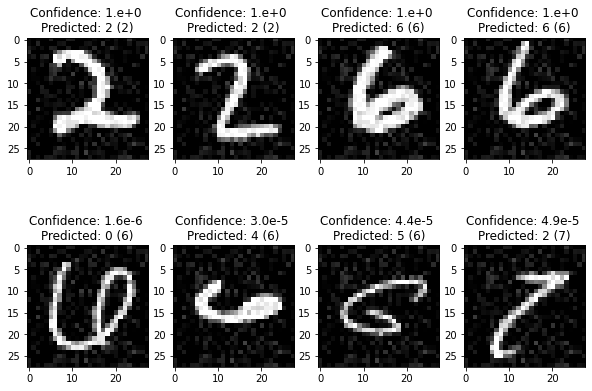

In [79]:
test_case = entry[3][0]
indexes_arr = np.concatenate((test_case[4], test_case[5]))
img_arr = np.concatenate((test_case[6], test_case[7]))
fig = plt.figure(figsize=(10, 7))
columns = 4
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_arr[i-1].reshape(28, 28), cmap="gray")
    plt.title(f'Confidence: {np.format_float_scientific(test_case[3][indexes_arr[i-1]], precision=1, exp_digits=1)} \nPredicted: {np.argmax(test_case[2][indexes_arr[i-1]])} ({mnist_test_targets[indexes_arr[i-1]]})')
plt.show()

- Per i migliori esempi, il rumore che bisogna aggiungere per far sbagliare la loro predizione al modello è:

Con rumore gaussiano in scala 1.0, riusciamo a rendere anche i migliori esempi irriconoscibili al modello


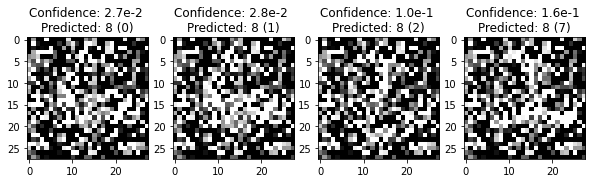

In [80]:
final_test_case = None
for _noise in range(100):
  noise = _noise/5.0
  test_data = _inject_Gaussian_noise_conv_from_linear(mnist_test_data[test_case[4]], noise)
  test_loss, test_accuracy, test_predictions, test_confidences, best_four, worst_four, class_f1_score = model_test_on(entry[0], test_data, mnist_test_targets[test_case[4]])
  final_test_case = (test_loss, test_accuracy, test_predictions, test_confidences, best_four, worst_four, test_data[best_four], test_data[worst_four], class_f1_score, noise)
  if test_accuracy==0.0:
    break

print(f'Con rumore gaussiano in scala {final_test_case[9]}, riusciamo a rendere anche i migliori esempi irriconoscibili al modello')

indexes_arr = final_test_case[4]
img_arr = final_test_case[6]
fig = plt.figure(figsize=(10, 3))
columns = 4
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_arr[i-1].reshape(28, 28), cmap="gray")
    plt.title(f'Confidence: {np.format_float_scientific(final_test_case[3][indexes_arr[i-1]], precision=1, exp_digits=1)} \nPredicted: {np.argmax(final_test_case[2][indexes_arr[i-1]])} ({mnist_test_targets[indexes_arr[i-1]]})')
plt.show()


b. Come cambia l’accuratezza di riconoscimento sui pattern di test rumorosi (curva psicometrica) se 
viene introdotto rumore anche nei pattern di training? E’ possibile stabilire un valore ottimale di 
rumore da aggiungere ai pattern di training, in modo da ottenere una migliore curva psicometrica?

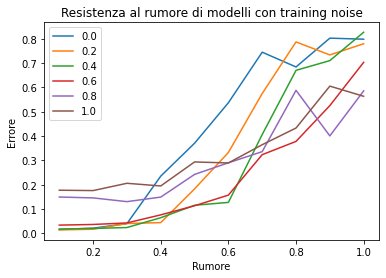

In [83]:

for entry in noised_models:
  errors = []
  for test_case in entry[3]:
    errors.append(1-test_case[1]) # 1-accuracy
  plt.plot(noise_levels_test, errors, label = f'{entry[1]}')
_ = plt.legend()
_ = plt.xlabel("Rumore")
_ = plt.ylabel("Errore")
_ = plt.title("Resistenza al rumore di modelli con training noise")

c. Come cambia l’accuratezza di riconoscimento sui pattern di test se viene drasticamente ridotto il 
numero di pattern di training (es: tenendo solo il 10% dei pattern)?

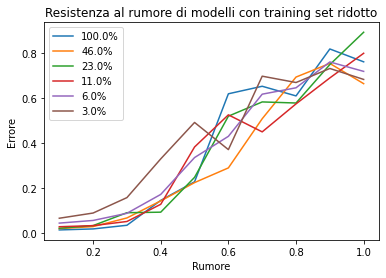

In [82]:
for entry in smaller_models:
  errors = []
  test_case = entry[3]
  for test_case in entry[3]:
    errors.append(1-test_case[1]) # 1-accuracy
  plt.plot(noise_levels_test, errors, label = f'{np.round(100*entry[1]/70000, 0)}%')
_ = plt.legend()
_ = plt.xlabel("Rumore")
_ = plt.ylabel("Errore")
_ = plt.title("Resistenza al rumore di modelli con training set ridotto")